<a href="https://colab.research.google.com/github/BrianMwangi21/btc-price-prediction-RNN/blob/main/BTC_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data, wb
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
import datetime
import plotly
import cufflinks as cf
cf.go_offline()
%matplotlib inline

In [2]:
# Set duration
start = datetime.datetime(2019, 4, 14)
end = datetime.datetime(2021, 4, 14)

In [3]:
# Import using DataReader
df = data.DataReader("BTC-USD",'yahoo',start,end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-04-13,5184.016113,5053.568359,5095.758789,5167.722168,1.039195e+10,5167.722168
2019-04-14,5196.606934,5024.069336,5167.321777,5067.108398,1.229016e+10,5067.108398
2019-04-15,5238.945312,5055.194824,5066.577637,5235.559570,1.161866e+10,5235.559570
2019-04-16,5274.275391,5219.205566,5236.135254,5251.937988,1.243848e+10,5251.937988
2019-04-17,5319.986328,5250.506836,5251.480469,5298.385742,1.325649e+10,5298.385742


In [4]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-04-09,61276.664062,58038.707031,58253.777344,59793.234375,5.823847e+10,59793.234375
2021-04-10,60790.554688,59289.796875,59846.230469,60204.964844,4.628025e+10,60204.964844
2021-04-11,61253.035156,59589.875000,60175.945312,59893.453125,5.182869e+10,59893.453125
2021-04-12,63742.285156,59869.957031,59890.019531,63503.457031,6.998345e+10,63503.457031
2021-04-14,64717.011719,63147.847656,63630.902344,63707.867188,7.023898e+10,63707.867188


In [5]:
# Exploratory Data Analysis
# Maximum Closing Rate
df.xs(key='Close',axis=1).max()

63707.8671875

In [ ]:
# Visualization (Closing Rate)
df.xs(key='Close',axis=1).iplot()

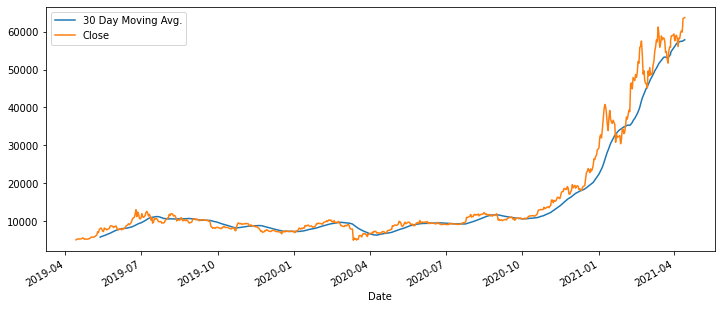

In [8]:
# 30-day Moving Average for Close Price
plt.figure(figsize=(12,5))
df['Close'].loc['2019-04-14':'2021-04-14'].rolling(window=30).mean().plot(label='30 Day Moving Avg.')
df['Close'].loc['2019-04-14':'2021-04-14'].plot(label='Close')
plt.legend()

In [ ]:
df0 = df[['Open','High','Low','Close']].loc['2019-04-14':'2021-04-14']
df0.iplot(kind='candle')

In [ ]:
df['Close'].loc['2019-04-14':'2021-04-14'].ta_plot(study='sma',periods=[9,18,27])

In [12]:
# Let's Reset the Index to Close
df1=df.reset_index()['Close']
df1

0       5167.722168
1       5067.108398
2       5235.559570
3       5251.937988
4       5298.385742
           ...     
723    59793.234375
724    60204.964844
725    59893.453125
726    63503.457031
727    63707.867188
Name: Close, Length: 728, dtype: float64

In [13]:
# Using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
print(df1)

In [15]:
# Splitting the Close data into Train and Test sets
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [16]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [17]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [18]:
print(X_train.shape), print(y_train.shape)

(408, 100)
(408,)


(None, None)

In [19]:
print(X_test.shape), print(y_test.shape)

(118, 100)
(118,)


(None, None)

In [20]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
# Stacked LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [22]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
7/7 [==============================] - 34s 252ms/step - loss: 0.0026 - val_loss: 0.2383
Epoch 2/100
7/7 [==============================] - 0s 28ms/step - loss: 6.6668e-04 - val_loss: 0.2694
Epoch 3/100
7/7 [==============================] - 0s 24ms/step - loss: 5.0328e-04 - val_loss: 0.2292
Epoch 4/100
7/7 [==============================] - 0s 22ms/step - loss: 4.3340e-04 - val_loss: 0.2472
Epoch 5/100
7/7 [==============================] - 0s 20ms/step - loss: 4.4448e-04 - val_loss: 0.2040
Epoch 6/100
7/7 [==============================] - 0s 19ms/step - loss: 3.8718e-04 - val_loss: 0.1706
Epoch 7/100
7/7 [==============================] - 0s 18ms/step - loss: 3.4605e-04 - val_loss: 0.1301
Epoch 8/100
7/7 [==============================] - 0s 18ms/step - loss: 2.6015e-04 - val_loss: 0.0739
Epoch 9/100
7/7 [==============================] - 0s 19ms/step - loss: 2.1603e-04 - val_loss: 0.0363
Epoch 10/100
7/7 [==============================] - 0s 19ms/step - loss: 1.9658e-04 

In [24]:
# Let's predict
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [25]:
# Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [26]:
### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

9283.721489051904

In [27]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

50019.332474983006

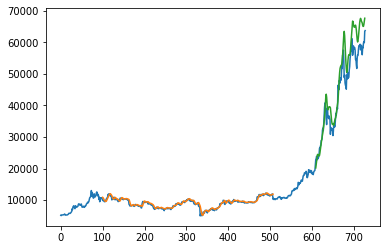

In [28]:
# Let's visualize
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [29]:
len(test_data)

219

In [31]:
x_input=test_data[118:].reshape(1,-1)
x_input.shape

(1, 101)

In [32]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

In [35]:
# Prediction for 30 days
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [36]:
len(df1)

728

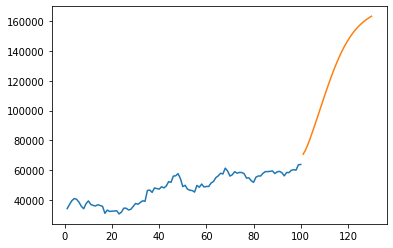

In [38]:
plt.plot(day_new,scaler.inverse_transform(df1[628:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

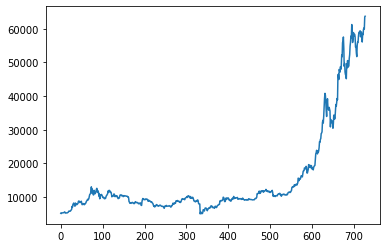

In [40]:
df3=scaler.inverse_transform(df1).tolist()
plt.plot(df3)